In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [17]:
df = pd.read_csv("Dataset/MSFT.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400
...,...,...,...,...,...,...,...
9078,2022-03-18,295.369995,301.000000,292.730011,300.429993,300.429993,43317000
9079,2022-03-21,298.890015,300.140015,294.899994,299.160004,299.160004,28351200
9080,2022-03-22,299.799988,305.000000,298.769989,304.059998,304.059998,27599700
9081,2022-03-23,300.510010,303.230011,297.720001,299.489990,299.489990,25715400


In [18]:
df = df[["Date", "Close"]]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9078,2022-03-18,300.429993
9079,2022-03-21,299.160004
9080,2022-03-22,304.059998
9081,2022-03-23,299.489990


In [19]:
df["Date"]

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9078    2022-03-18
9079    2022-03-21
9080    2022-03-22
9081    2022-03-23
9082    2022-03-24
Name: Date, Length: 9083, dtype: object

In [20]:
def str_to_datetime(s):
    split = s.split("-")
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


datetime_object = str_to_datetime("1986-03-19")
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [21]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9078,2022-03-18,300.429993
9079,2022-03-21,299.160004
9080,2022-03-22,304.059998
9081,2022-03-23,299.489990


In [22]:
df["Date"] = df["Date"].apply(str_to_datetime)
df["Date"]

C:\Users\ASHUTOSH\AppData\Local\Temp\ipykernel_11688\1677453681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df["Date"].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9078   2022-03-18
9079   2022-03-21
9080   2022-03-22
9081   2022-03-23
9082   2022-03-24
Name: Date, Length: 9083, dtype: datetime64[ns]

In [23]:
df.index = df.pop("Date")
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-03-18,300.429993
2022-03-21,299.160004
2022-03-22,304.059998


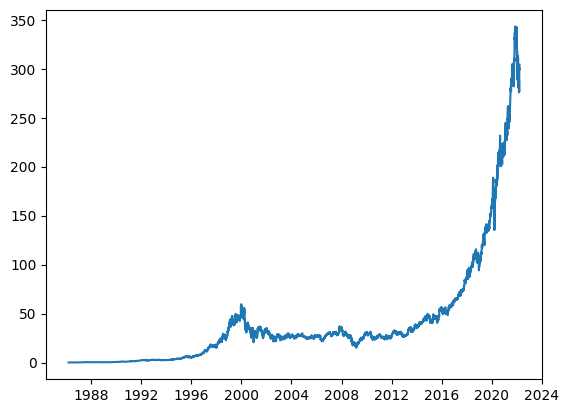

In [24]:
plt.plot(df.index, df["Close"])

In [31]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f"Error: Window of size {n} is too large for date {target_date}")
            return

        values = df_subset["Close"].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[
            target_date : target_date + datetime.timedelta(days=7)
        ]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split("T")[0]
        year_month_day = next_date_str.split("-")
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df["Target Date"] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f"Target-{n-i}"] = X[:, i]

    ret_df["Target"] = Y

    return ret_df


# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, "2021-03-25", "2022-03-23", n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [32]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)


dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

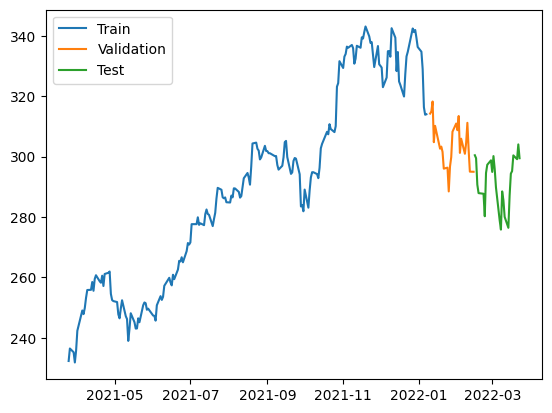

In [33]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(["Train", "Validation", "Test"])

In [34]:
# Define the LSTM model
model = Sequential(
    [
        layers.Input(shape=(3, 1)),
        layers.LSTM(64, activation="tanh", return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),  # Output layer for regression
    ]
)

# Compile the model
model.compile(
    loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["mean_absolute_error"]
)



# Train the model
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 83940.4844 - mean_absolute_error: 287.9370 - val_loss: 92321.0000 - val_mean_absolute_error: 303.7565
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 84181.3828 - mean_absolute_error: 288.4260 - val_loss: 92075.7734 - val_mean_absolute_error: 303.3526
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 84493.1172 - mean_absolute_error: 288.9950 - val_loss: 91795.1094 - val_mean_absolute_error: 302.8897
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 83414.5000 - mean_absolute_error: 287.1300 - val_loss: 91407.8594 - val_mean_absolute_error: 302.2497
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 82768.7031 - mean_absolute_error: 286.0006 - val_loss: 90957.8672 - val_mean_absolute_error: 301.5044
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 82527.6875 - mean_absolute_error: 285.5415 - val_loss: 90404.9688 - val_mean_absolute_error: 300.5861
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


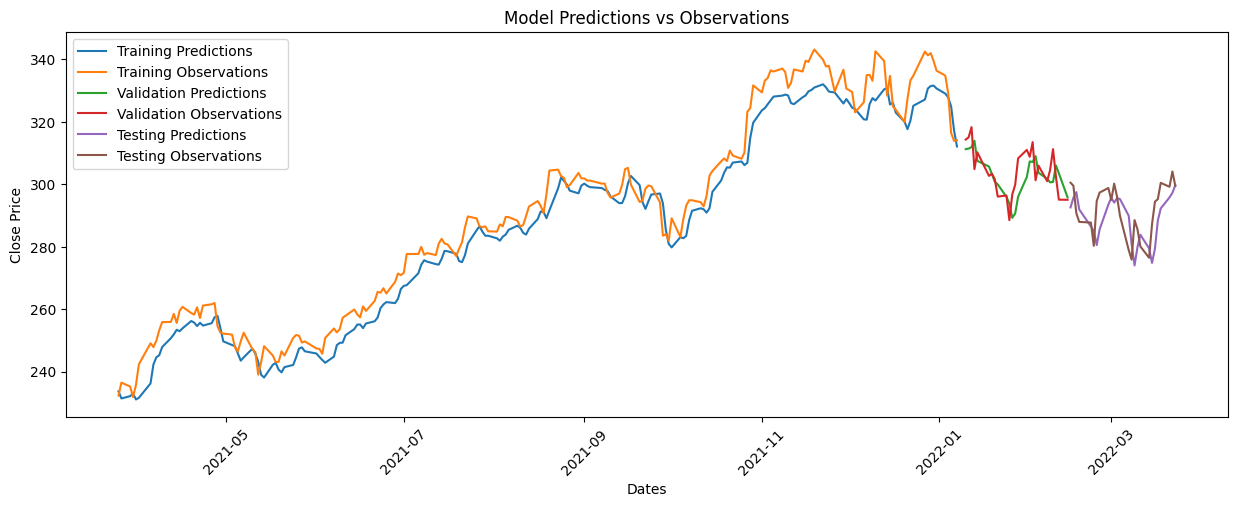

In [35]:
# Plot predictions
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(15, 5))
plt.plot(dates_train, train_predictions, label="Training Predictions")
plt.plot(dates_train, y_train, label="Training Observations")
plt.plot(dates_val, val_predictions, label="Validation Predictions")
plt.plot(dates_val, y_val, label="Validation Observations")
plt.plot(dates_test, test_predictions, label="Testing Predictions")
plt.plot(dates_test, y_test, label="Testing Observations")
plt.legend()
plt.title("Model Predictions vs Observations")
plt.xlabel("Dates")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.show()

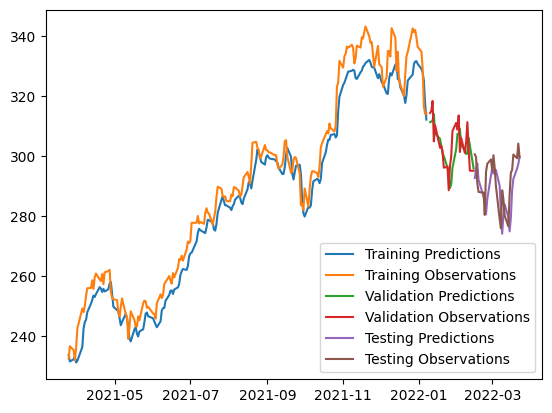

In [36]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(
    [
        "Training Predictions",
        "Training Observations",
        "Validation Predictions",
        "Validation Observations",
        "Testing Predictions",
        "Testing Observations",
    ]
)

In [43]:
from copy import deepcopy

# Initialize predictions
recursive_predictions = []

# Start with the last window of the training data
last_window = deepcopy(X_train[-1])

# Concatenate validation and test dates for predictions
recursive_dates = np.concatenate([dates_val, dates_test])

# Generate recursive predictions
for target_date in recursive_dates:
    # Predict using the current window
    next_prediction = model.predict(np.array([last_window])).flatten()

    # Store the prediction
    recursive_predictions.append(next_prediction)

    # Update the sliding window (shift left and add new prediction)
    last_window[:-1] = last_window[1:]
    last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

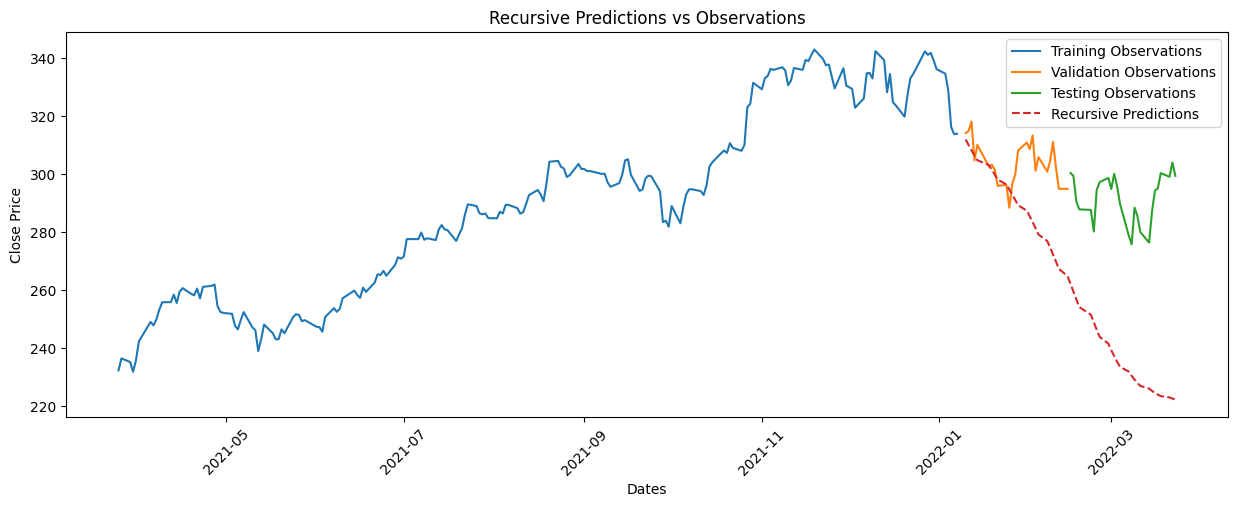

In [44]:
# Plot results
plt.figure(figsize=(15, 5))
plt.plot(dates_train, y_train, label="Training Observations")
plt.plot(dates_val, y_val, label="Validation Observations")
plt.plot(dates_test, y_test, label="Testing Observations")
plt.plot(
    recursive_dates,
    recursive_predictions,
    label="Recursive Predictions",
    linestyle="--",
)
plt.legend()
plt.title("Recursive Predictions vs Observations")
plt.xlabel("Dates")
plt.ylabel("Close Price")
plt.xticks(rotation=45)
plt.show()